# Implementing and training a one hidden layer fully-connected network to classify MNIST digits using PyTorch.

This notebook illustrates how we would iterate through the following workflow in PyTorch:
* Defining a model
* Fetching batches of training data
* Obtaining model predictions
* Computing the loss
* Computing gradient of the loss wrt model parameters
* Updating the model parameters using some gradient-based optimization method.

Acknowledgments: based on official PyTorch tutorials.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# You should set a random seed to ensure that your results are reproducible.
torch.manual_seed(0)

### Defining a model

It's usually a good idea to define your model as classes which inherit from `nn.Module`. The parameters of any submodules of the `torch.nn` module that you declare attributes of the class (e.g. `nn.Linear` below) will automatically be registered as parameters of your model, which will prove to be convenient when constructing an optimizer, as we shall see below.

In [3]:
class OneHiddenLayerMNISTClassifier(nn.Module):
    # Define entities containing model weights in the constructor.
    def __init__(self, n_hidden):
        super().__init__()
        self.linear1 = nn.Linear(
            in_features=784, out_features=n_hidden, bias=True
        )
        self.linear2 = nn.Linear(
            in_features=n_hidden, out_features=10, bias=True
        )
        print(self.linear1)

    # Then, all you need to do is implement a `forward` method to define the
    # computation that takes place on the forward pass. A corresponding
    # `backward` method, which computes gradients, is automatically defined!
    def forward(self, inputs):
        h = self.linear1(inputs.view(-1, 784))
        h = F.relu(h)
        h = self.linear2(h)
        return F.log_softmax(h, dim=1)

We'll also define some utility functions that perform a single iteration of training and evalution:

In [4]:
def train(model, train_loader, optimizer, epoch, log_interval=100):
    """
    A utility function that performs a basic training loop.

    For each batch in the training set, fetched using `train_loader`:
        - Zeroes the gradient used by `optimizer`
        - Performs forward pass through `model` on the given batch
        - Computes loss on batch
        - Performs backward pass
        - `optimizer` updates model parameters using computed gradient

    Prints the training loss on the current batch every `log_interval` batches.
    """
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Zeroes the gradient used by `optimizer`; NOTE: if this is not done,
        # then gradients will be accumulated across batches!
        optimizer.zero_grad()

        # Performs forward pass through `model` on the given batch; equivalent
        # to `model.forward(inputs)`. Any information needed to compute
        # gradients is automatically thanks to autograd running under the hood.
        outputs = model(inputs)

        # Computes loss on batch; `F.nll_loss` computes the mean negative log-
        # likelihood on the batch.
        loss = F.nll_loss(outputs, targets)

        # Performs backward pass; steps backward through the computation graph,
        # computing the gradient of the loss wrt model parameters.
        loss.backward()

        # `optimizer` updates model parameters using computed gradient.
        optimizer.step()

        # Prints the training loss on the current batch every `log_interval`
        # batches.
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {:02d} -- Batch: {:03d} -- Loss: {:.4f}".format(
                    epoch,
                    batch_idx,
                    # Calling `loss.item()` returns the scalar loss as a Python
                    # number.
                    loss.item(),
                )
            )


def test(model, test_loader):
    """
    A utility function to compute the loss and accuracy on a test set by
    iterating through the test set using the provided `test_loader` and
    accumulating the loss and accuracy on each batch.
    """
    test_loss = 0.0
    correct = 0

    # You should use the `torch.no_grad()` context when you want to perform a
    # forward pass but do not need gradients. This effectively disables
    # autograd and results in less resources being used to perform the forward
    # pass (since information needed to compute gradients is not logged).
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            # We use `reduction="sum"` to aggregate losses across batches using
            # summation instead of taking the mean - we will take the mean at
            # the end once we have accumulated all the losses.
            test_loss += F.nll_loss(outputs, targets, reduction="sum").item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(targets.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {:.4f}\n".format(
            test_loss, correct / len(test_loader.dataset)
        )
    )

### Fetching data

* https://pytorch.org/docs/stable/data.html
* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

<bound method MNIST.__len__ of Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: data/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None>

shape of sample target is ----- tensor(6)
shape of sample image is ----- torch.Size([1, 28, 28])


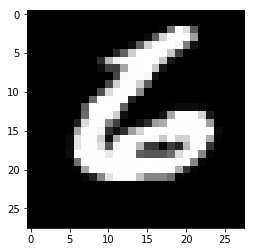

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

sample_image, sample_target = test_dat[9999]

print(test_dat.__len__)
print()

print('shape of sample target is -----',sample_target)


print('shape of sample image is -----',sample_image.shape)
plt.imshow(sample_image.squeeze(), cmap='gray')

torch.Size([64, 1, 28, 28]) torch.Size([64]) 

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242

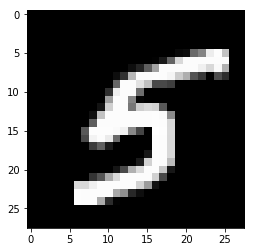

In [6]:
# Create dataloaders
train_loader = DataLoader(train_dat, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dat, batch_size=1024, shuffle=False)

it = iter(train_loader)
sample_inputs, sample_targets = next(it)

print(sample_inputs.shape, sample_targets.shape, '\n')
plt.imshow(sample_inputs[0].squeeze(), cmap='gray')

print(sample_inputs)
print(sample_targets)



### Running the training loop

In [7]:
# Create instance of model
model = OneHiddenLayerMNISTClassifier(n_hidden=32)

# Create instance of optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# # Train-test loop
# for epoch in range(3):
#     train(model, train_loader, optimizer, epoch)
#     test(model, test_loader)

Linear(in_features=784, out_features=32, bias=True)


### Saving and loading model weights

In [8]:
# Saving / restoring model weights
torch.save(model.state_dict(), "mnist_fc_model.pt")
model.load_state_dict(torch.load("mnist_fc_model.pt"))